In [1]:
from IPython.display import clear_output
!pip install --upgrade yfinance
!pip install pmdarima
clear_output()

# Imports

In [2]:
import yfinance as yf
import pandas as pd
from datetime import datetime
import requests
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm import tqdm

# Setup gpu

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    
    tf.config.experimental.set_memory_growth(gpus[0], True)

Num GPUs Available:  1


# Download dataset

In [4]:
def getDataset(ticker):
    data = yf.download(ticker, start="2010-01-01", end="2024-12-22")
    
    if 'Adj Close' not in data.columns:
        url = 'https://drive.google.com/uc?id=16CGEJ-HywRBys2ac4aZO7l3XZT99xw_y'  # Direct download link
        try:
            response = requests.get(url)
            response.raise_for_status()  
            data = pd.read_csv(StringIO(response.text))
            data.drop(index = 0, inplace=True)
            data.drop(index = 1, inplace=True)
            data.to_csv("crude_oil_prices.csv")
            data = pd.read_csv('/kaggle/working/crude_oil_prices.csv', index_col=False)
            data.drop(columns=['Unnamed: 0'], inplace=True)
            data.rename(columns={'Price': 'Date'}, inplace=True)
            data['Date'] = pd.to_datetime(data['Date'])
        except requests.exceptions.RequestException as e:
            print(f"Error downloading alternative CSV: {e}")
            return None     
    return data

In [5]:
data = getDataset("CL=F")
data.head(10)

[*********************100%***********************]  1 of 1 completed


,Date,Adj Close,Close,High,Low,Open,Volume
0,2010-01-04,81.510002,81.510002,81.680000,79.629997,79.629997,263542
1,2010-01-05,81.769997,81.769997,82.000000,80.949997,81.629997,258887
2,2010-01-06,83.180000,83.180000,83.519997,80.849998,81.430000,370059
3,2010-01-07,82.660004,82.660004,83.360001,82.260002,83.199997,246632
4,2010-01-08,82.750000,82.750000,83.470001,81.800003,82.650002,310377
5,2010-01-11,82.519997,82.519997,83.949997,81.959999,82.879997,296304
6,2010-01-12,80.790001,80.790001,82.339996,79.910004,82.070000,333866
7,2010-01-13,79.650002,79.650002,80.669998,78.370003,80.059998,401627
8,2010-01-14,79.389999,79.389999,80.360001,78.919998,79.629997,275404
9,2010-01-15,78.000000,78.000000,79.309998,77.699997,79.199997,200555


In [6]:
print(data.dtypes)

Date         datetime64[ns]
Adj Close           float64
Close               float64
High                float64
Low                 float64
Open                float64
Volume                int64
dtype: object


In [7]:
def printNullsCount(data):
    null_counts = data.isnull().sum()
    print(null_counts)

In [8]:
def nullify_adj_close(data):
    if 'Adj Close' not in data.columns:
        raise ValueError("DataFrame must contain 'Adj Close' column.")
    
    rows_to_nullify = data[data['Adj Close'] < 0].index
    
    columns_to_nullify = data.columns[data.columns != 'Date']
    
    data.loc[rows_to_nullify, columns_to_nullify] = np.nan
    
    return data

In [9]:
def nullify(data, percentage, randomSeed):
    np.random.seed(randomSeed)

    missing_indices = np.random.choice(data.index, size=int(percentage * len(data)), replace=False)
    
    columns_to_nullify = data.columns.get_level_values(0) != 'Date'
    
    data.loc[missing_indices, columns_to_nullify] = np.nan
    
    return data

In [10]:
data = nullify_adj_close(data)
data = nullify(data, 0.1, 42)

In [11]:
printNullsCount(data)

Date           0
Adj Close    377
Close        377
High         377
Low          377
Open         377
Volume       377
dtype: int64


In [12]:
def fillMissedDatesWithNull(data, start, end, freq):
    data.set_index('Date', inplace=True)

    full_date_range = pd.date_range(start=start, end=end, freq=freq)
    
    df_reindexed = data.reindex(full_date_range)
    
    df_reindexed.reset_index(inplace=True)
    df_reindexed.rename(columns={'index': 'Date'}, inplace=True)
    return df_reindexed

In [13]:
df_reindexed = fillMissedDatesWithNull(data, '2010-01-01', '2024-12-18', 'D')
printNullsCount(df_reindexed)

Date            0
Adj Close    2080
Close        2080
High         2080
Low          2080
Open         2080
Volume       2080
dtype: int64


In [14]:
def fillMissingValues(df, method):
    df.set_index('Date', inplace=True)
    interpolated_df = df.interpolate(method=method, inplace=False).dropna()
    interpolated_df.reset_index(inplace=True)
    interpolated_df.rename(columns={'index': 'Date'}, inplace=True)
    return interpolated_df

In [15]:
interpolated_df = fillMissingValues(df_reindexed, 'time')
printNullsCount(interpolated_df)

Date         0
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64


In [16]:
def DateToDays(df, timestamp):
    reference_date = pd.Timestamp(timestamp)
    df['Days'] = (df['Date'] - reference_date).dt.days 
    df.drop(columns=['Date'], inplace=True)
    return df

In [17]:
original_dates = interpolated_df['Date'].copy()
interpolated_df = DateToDays(interpolated_df, "2000-01-01")
interpolated_df

,Adj Close,Close,High,Low,Open,Volume,Days
0,81.510002,81.510002,81.680000,79.629997,79.629997,263542.0,3656
1,81.769997,81.769997,82.000000,80.949997,81.629997,258887.0,3657
2,83.180000,83.180000,83.519997,80.849998,81.430000,370059.0,3658
3,82.660004,82.660004,83.360001,82.260002,83.199997,246632.0,3659
4,82.750000,82.750000,83.470001,81.800003,82.650002,310377.0,3660
...,...,...,...,...,...,...,...
5458,70.043999,70.043999,70.800000,69.156000,70.502000,277346.0,9114
5459,70.056000,70.056000,70.839999,69.164000,70.538000,252996.0,9115
5460,70.068001,70.068001,70.879999,69.172000,70.574001,228646.0,9116
5461,70.080002,70.080002,70.919998,69.180000,70.610001,204296.0,9117


In [18]:
originalDays= interpolated_df['Days'].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Days']
interpolated_df[scaled_columns] = scaler.fit_transform(interpolated_df[scaled_columns])
interpolated_df

,Adj Close,Close,High,Low,Open,Volume,Days
0,81.510002,0.628903,0.582056,0.700720,0.675249,0.115173,0.000000
1,81.769997,0.631190,0.584796,0.710318,0.689673,0.113139,0.000183
2,83.180000,0.643592,0.597808,0.709591,0.688230,0.161723,0.000366
3,82.660004,0.639018,0.596439,0.719843,0.700995,0.107783,0.000549
4,82.750000,0.639810,0.597380,0.716498,0.697029,0.135641,0.000732
...,...,...,...,...,...,...,...
5458,70.043999,0.528050,0.488914,0.624562,0.609419,0.121205,0.999268
5459,70.056000,0.528156,0.489256,0.624620,0.609678,0.110564,0.999451
5460,70.068001,0.528261,0.489598,0.624678,0.609938,0.099923,0.999634
5461,70.080002,0.528367,0.489941,0.624736,0.610198,0.089281,0.999817


In [19]:
def create_dataset(features, target, time_step=10):
    X, y = [], []
    for i in range(len(features) - time_step - 1):
        X.append(features[i:(i + time_step)])
        y.append(target[i + time_step])  
    return np.array(X), np.array(y)

def split_dataset(features, target, test_size=0.2):
    split_idx = int(len(features) * (1 - test_size))
    X_train, X_test = features[:split_idx], features[split_idx:]
    y_train, y_test = target[:split_idx], target[split_idx:]
    return X_train, X_test, y_train, y_test

In [20]:
adj_close = interpolated_df['Adj Close'].values  
values = interpolated_df[scaled_columns].values

time_step = 2
X, y = create_dataset(values, adj_close, time_step=time_step)
X = X.reshape(X.shape[0], X.shape[1], len(scaled_columns))  

X_train, X_test, y_train, y_test = split_dataset(X, y, test_size=0.3)


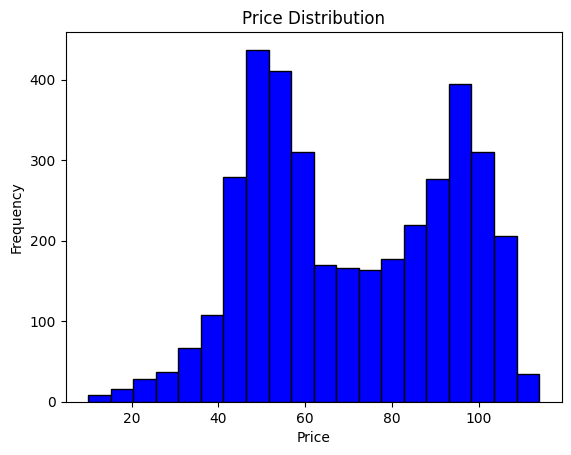

In [21]:
plt.hist(y_train, bins='auto', color='blue', edgecolor='black')
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

In [22]:
def create_model(model_type="LSTM", units=512, input_shape=(10, 6)):
    model = Sequential()
    if model_type == "LSTM":
        model.add(LSTM(units, return_sequences=False, input_shape=input_shape))
    elif model_type == "Bi-LSTM":
        model.add(Bidirectional(LSTM(units, return_sequences=False), input_shape=input_shape))
    elif model_type == "GRU":
        model.add(GRU(units, return_sequences=False, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(1))  # Output layer
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

def plot_results(y_train, y_test, y_test_pred, original_dates, train_len, time_step=2):
    plt.figure(figsize=(12, 8))
    
    train_dates = original_dates[:train_len]
    test_dates = original_dates[train_len + time_step:train_len + time_step + len(y_test)]
    
    plt.plot(train_dates, y_train, label="Train Data", color='blue')
    
    plt.plot(test_dates, y_test, label="Test Data", color='green', alpha=0.7)
    
    plt.plot(test_dates, y_test_pred, label="Test Predictions", color='red', alpha=0.5)
    
    plt.title("Model Results with Actual Dates")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid()
    plt.show()




In [23]:
def train_and_evaluate(model_type, units):
    print(f"Training {model_type} model...")
    model = create_model(model_type=model_type, units=units, input_shape=X_train.shape[1:])
    history = model.fit(X_train, y_train, epochs=50, batch_size=100, verbose=1, validation_data=(X_test, y_test))
    
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    
    train_mae = mean_absolute_error(y_train, train_predict)
    test_mae = mean_absolute_error(y_test, test_predict)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
    
    train_r2 = r2_score(y_train, train_predict)
    test_r2 = r2_score(y_test, test_predict)
    
    train_mape = np.mean(np.abs((y_train - train_predict) / y_train)) * 100
    test_mape = np.mean(np.abs((y_test - test_predict) / y_test)) * 100
    
    print(f"Training MAE: {train_mae:.4f}")
    print(f"Test MAE: {test_mae:.4f}")
    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Test R²: {test_r2:.4f}")
    print(f"Training MAPE: {train_mape:.4f}%")
    print(f"Test MAPE: {test_mape:.4f}%")
    
    train_len = len(y_train)
    plot_results(y_train, y_test, test_predict, original_dates, train_len, time_step=time_step)
    
    return history


Training LSTM model...


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 5297.0449 - val_loss: 2930.4202
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1989.2167 - val_loss: 509.3891
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 555.9764 - val_loss: 270.8616
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 432.3810 - val_loss: 224.1185
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 363.5802 - val_loss: 179.1684
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 265.4071 - val_loss: 122.6009
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 162.6241 - val_loss: 76.3806
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 74.4940 - val_loss: 51.5489
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 42.4996 - val_loss: 43.2587
Epoch 10/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 32.8158 - val_loss: 37.3658
Epoch 11/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 29.0770 - val_loss: 35.4261
Epoch 12/50
39/39 ━━━━━━━━━━━━━━━━━

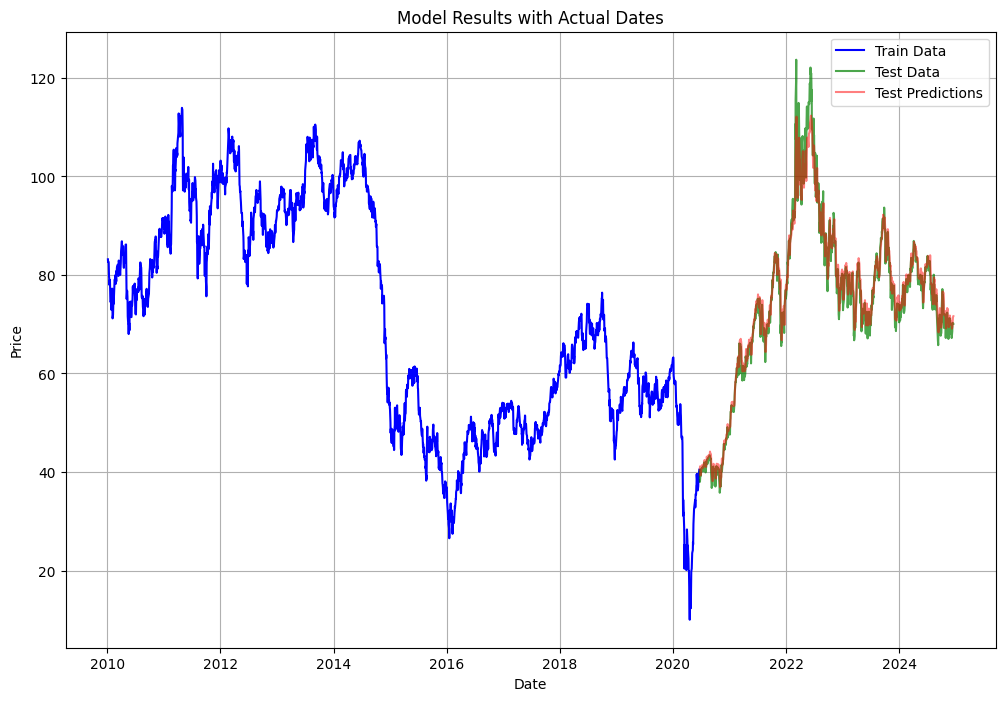

In [24]:
lstm_history = train_and_evaluate("LSTM", units=512)


Training Bi-LSTM model...


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4707.4907 - val_loss: 197.1262
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 326.5246 - val_loss: 85.3705
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 135.6046 - val_loss: 32.0171
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 31.6048 - val_loss: 16.9295
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.2677 - val_loss: 15.2563
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.9729 - val_loss: 13.0583
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.8233 - val_loss: 10.1268
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.2461 - val_loss: 7.9331
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.5326 - val_loss: 6.8326
Epoch 10/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.0585 - val_loss: 6.5282
Epoch 11/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.4777 - val_loss: 6.3445
Epoch 12/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/

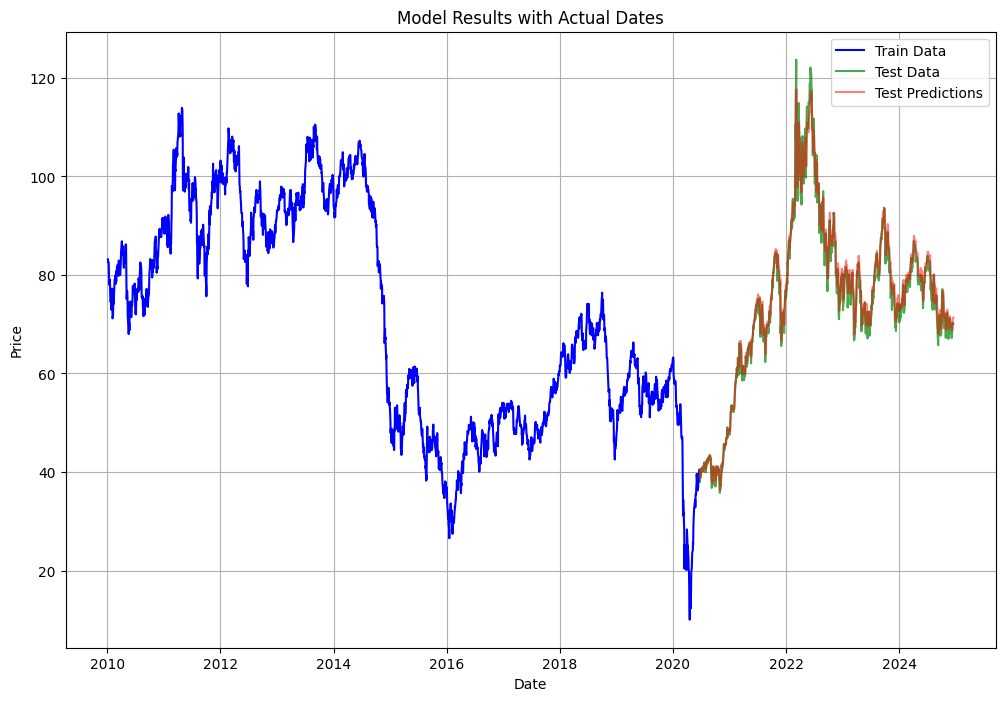

In [25]:
bilstm_history = train_and_evaluate("Bi-LSTM", units=1024)

Training GRU model...
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5077.5664 - val_loss: 1289.7823
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 957.6318 - val_loss: 347.8969
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 500.1726 - val_loss: 271.3102
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 428.1177 - val_loss: 215.5959
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 294.6774 - val_loss: 116.3378
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 108.1044 - val_loss: 71.2183
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 46.8515 - val_loss: 54.4135
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 36.7391 - val_loss: 39.6431
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 29.2301 - val_loss: 33.1872
Epoch 10/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 24.0382 - val_loss: 30.5296
Epoch 11/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.4428 - val_loss: 24.0457
Epoch 12/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

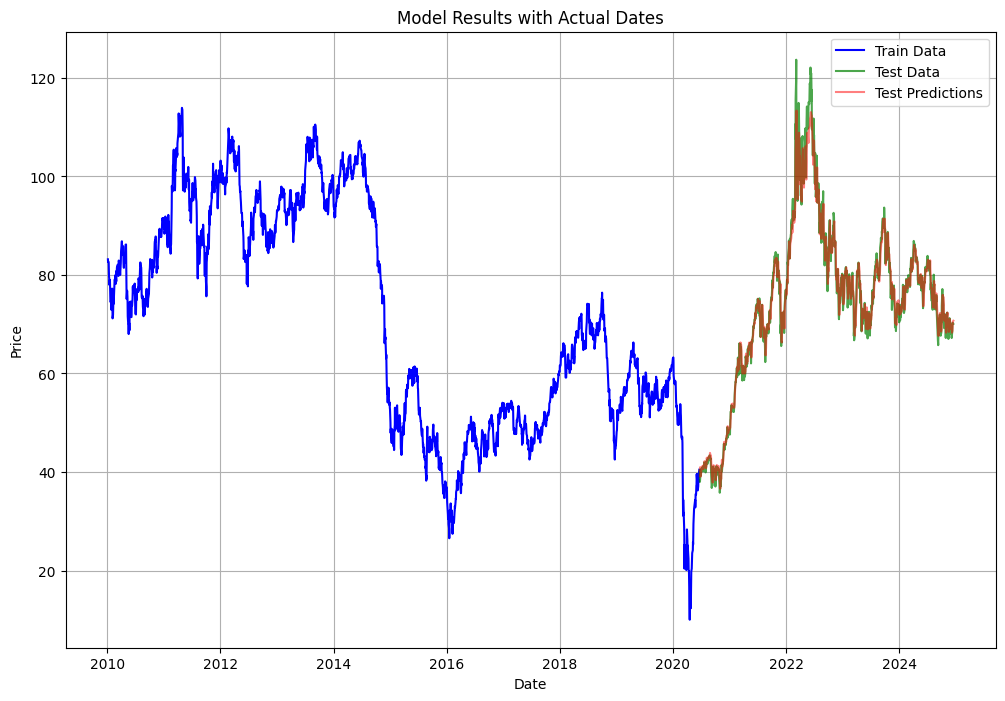

In [26]:
gru_history = train_and_evaluate("GRU", units=512)

## ARIMA

In [27]:
import pmdarima as pm
from sklearn.metrics import mean_squared_error

In [28]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima



Finding best ARIMA parameters...
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10774.379, Time=0.85 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10797.365, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10776.519, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10777.954, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10795.814, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=10776.287, Time=0.82 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=10776.276, Time=1.55 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=10775.236, Time=0.44 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=10774.670, Time=0.26 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=10778.345, Time=0.93 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=10772.727, Time=0.45 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=10776.347, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=10774.904, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=10774.639,

Rolling Forecast Progress: 100%|██████████| 1639/1639 [10:28<00:00,  2.61it/s]



Test Metrics:
MAE: 0.8683, RMSE: 1.3792, R-Squared: 0.9934, MAPE: 1.13%


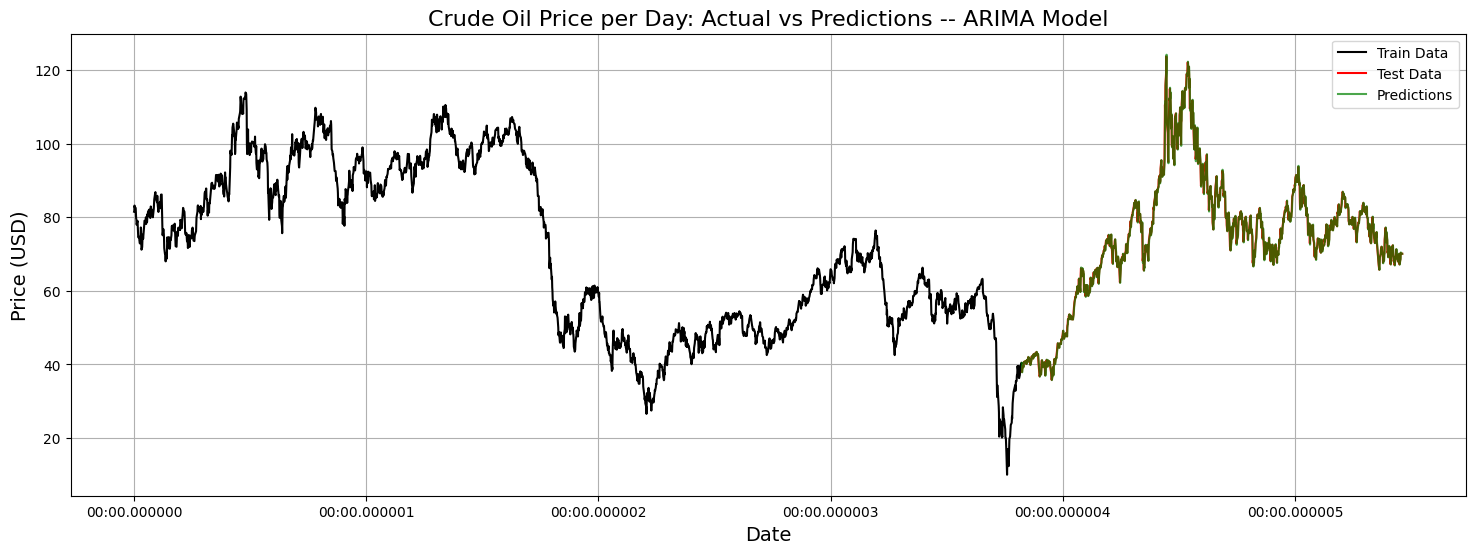

In [29]:
def scale_data(series):
    """Scale the data using MinMaxScaler."""
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = series.values.reshape(-1, 1).flatten()
    return scaled_data, scaler

def split_data(scaled_data, train_ratio=0.8):
    """Split the data into train and test sets."""
    train_size = int(len(scaled_data) * train_ratio)
    train_data = scaled_data[:train_size]
    test_data = scaled_data[train_size:]
    return train_data, test_data

def find_best_arima(train_data):
    """Find the best ARIMA parameters using auto_arima."""
    print("\nFinding best ARIMA parameters...")
    auto_model = auto_arima(
        train_data,
        start_p=1, start_q=1,
        max_p=5, max_q=5,
        d=None,
        seasonal=False,
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True
    )
    print(f"Best ARIMA parameters: {auto_model.order}")
    return auto_model.order

def rolling_forecast(train_data, test_data, order):
    """Perform rolling forecasts with ARIMA."""
    rolling_predictions = []
    history = list(train_data)

    print("\nGenerating rolling forecasts...")
    for actual in tqdm(test_data, desc="Rolling Forecast Progress"):
        model = ARIMA(history, order=order)
        model_fit = model.fit()

        forecast = model_fit.forecast(steps=1)[0]
        rolling_predictions.append(forecast)

        history.append(actual)
    return rolling_predictions

def calculate_metrics(actual, predicted):
    """Calculate MAE, RMSE, R-squared, and MAPE."""
    mae = np.mean(np.abs(actual - predicted))
    rmse = np.sqrt(np.mean((actual - predicted) ** 2))
    r2 = 1 - (np.sum((actual - predicted) ** 2) / np.sum((actual - np.mean(actual)) ** 2))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mae, rmse, r2, mape

def plot_results(data, train_size, actual_test_data, rolling_predictions, train_data):
    """Plot the train data, test data, and predictions."""
    plt.figure(figsize=(18, 6))
    plt.plot(data.index[:train_size], train_data.reshape(-1, 1), label='Train Data', color='black')
    plt.plot(data.index[train_size:], actual_test_data, label='Test Data', color='red')
    plt.plot(data.index[train_size:], rolling_predictions, label='Predictions', color='green', alpha = 0.7)
    plt.title('Crude Oil Price per Day: Actual vs Predictions -- ARIMA Model', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Price (USD)', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()

def main_arima_sarima(data, train_ratio=0.8):
    # Step 1: Scale the data
    scaled_data, scaler = scale_data(data['Adj Close'])

    # Step 2: Split the data
    train_data, test_data = split_data(scaled_data, train_ratio)
    train_size = len(train_data)

    # Step 3: Find the best ARIMA parameters
    order = find_best_arima(train_data)

    # Step 4: Perform rolling forecasts
    rolling_predictions = rolling_forecast(train_data, test_data, order)

    # Step 5: Inverse scaling
    actual_test_data = test_data.reshape(-1, 1).flatten()
    rolling_predictions = np.array(rolling_predictions).reshape(-1, 1).flatten()

    # Step 6: Calculate metrics
    metrics = calculate_metrics(actual_test_data, rolling_predictions)
    print(f"\nTest Metrics:\nMAE: {metrics[0]:.4f}, RMSE: {metrics[1]:.4f}, R-Squared: {metrics[2]:.4f}, MAPE: {metrics[3]:.2f}%")

    # Step 7: Plot the results
    plot_results(data, train_size, actual_test_data, rolling_predictions, train_data)

# Example Usage
data = interpolated_df[['Adj Close']].copy()
data.index = pd.to_datetime(data.index)  # Ensure datetime index
main_arima_sarima(data, train_ratio=0.7)


Finding best SARIMA parameters...
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=10774.379, Time=0.77 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=10797.365, Time=0.17 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=10778.336, Time=0.71 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=10779.759, Time=1.11 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=10795.814, Time=0.08 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=10776.259, Time=3.79 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=10776.260, Time=2.16 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=10778.244, Time=2.98 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=10777.954, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=10776.519, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=10776.287, Time=0.72 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=10776.276, Time=1.20 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=10775.236, Time=0.33 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   :

Rolling Forecast Progress: 100%|██████████| 1639/1639 [10:24<00:00,  2.63it/s]



Test Metrics:
MAE: 0.8683, RMSE: 1.3792, R-Squared: 0.9934, MAPE: 1.13%


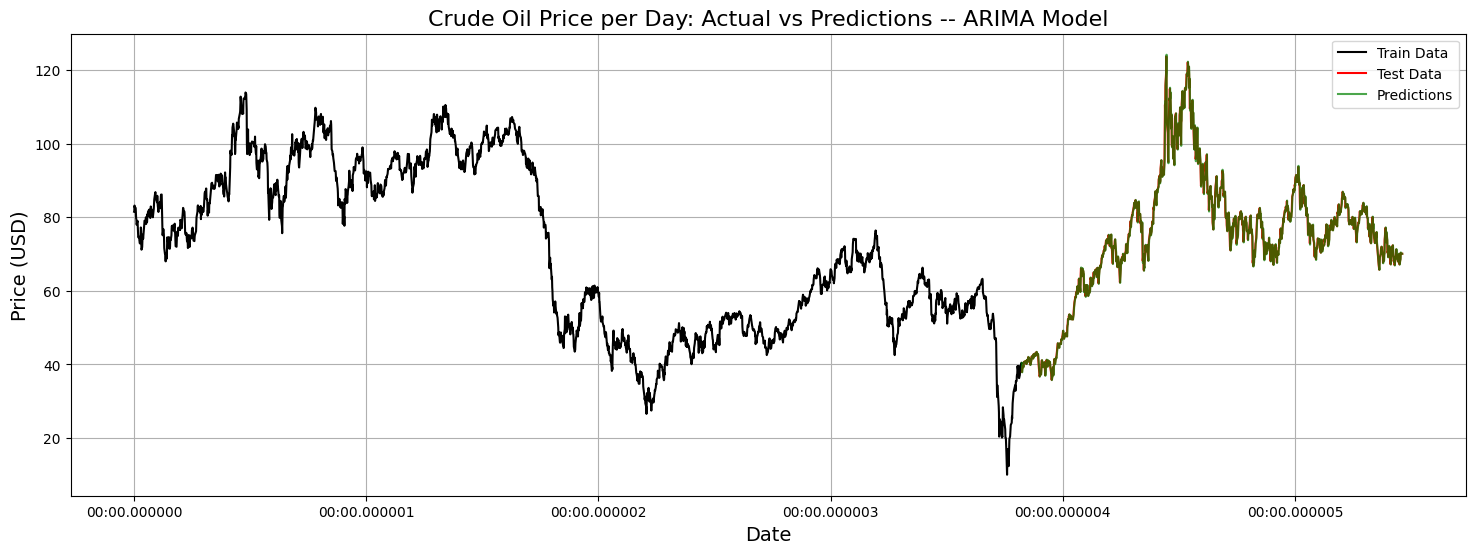

In [30]:
 from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm

def find_best_sarima(train_data, seasonality=12):
    """Find the best SARIMA parameters using auto_arima."""
    print("\nFinding best SARIMA parameters...")
    auto_model = auto_arima(
        train_data,
        start_p=1, start_q=1,
        max_p=5, max_q=5,
        d=None,
        seasonal=True,
        m=seasonality,  # Seasonality period
        start_P=0, start_Q=0,
        max_P=2, max_Q=2,
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True
    )
    print(f"Best SARIMA parameters: {auto_model.order}")
    print(f"Best Seasonal Order: {auto_model.seasonal_order}")
    return auto_model.order, auto_model.seasonal_order

def rolling_forecast_sarima(train_data, test_data, order, seasonal_order):
    """Perform rolling forecasts with SARIMA."""
    rolling_predictions = []
    history = list(train_data)

    print("\nGenerating rolling forecasts with SARIMA...")
    for actual in tqdm(test_data, desc="Rolling Forecast Progress"):
        model = SARIMAX(history, order=order, seasonal_order=seasonal_order)
        model_fit = model.fit(disp=False)

        forecast = model_fit.forecast(steps=1)[0]
        rolling_predictions.append(forecast)

        history.append(actual)
    return rolling_predictions

def main_sarima(data, train_ratio=0.8, seasonality=12):
    # Step 1: Scale the data
    scaled_data, scaler = scale_data(data['Adj Close'])

    # Step 2: Split the data
    train_data, test_data = split_data(scaled_data, train_ratio)
    train_size = len(train_data)

    # Step 3: Find the best SARIMA parameters
    order, seasonal_order = find_best_sarima(train_data, seasonality)

    # Step 4: Perform rolling forecasts
    rolling_predictions = rolling_forecast_sarima(train_data, test_data, order, seasonal_order)

    # Step 5: Inverse scaling
    actual_test_data = test_data.reshape(-1, 1).flatten()
    rolling_predictions = np.array(rolling_predictions).reshape(-1, 1).flatten()

    # Step 6: Calculate metrics
    metrics = calculate_metrics(actual_test_data, rolling_predictions)
    print(f"\nTest Metrics:\nMAE: {metrics[0]:.4f}, RMSE: {metrics[1]:.4f}, R-Squared: {metrics[2]:.4f}, MAPE: {metrics[3]:.2f}%")

    # Step 7: Plot the results
    plot_results(data, train_size, actual_test_data, rolling_predictions, train_data)

# Example Usage
data = interpolated_df[['Adj Close']].copy()
data.index = pd.to_datetime(data.index)  # Ensure datetime index
main_sarima(data, train_ratio=0.7, seasonality=12)
